<a href="https://colab.research.google.com/github/npinto97/ICON3_22-23/blob/main/ProgettoICON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Progetto icon

Import delle dipendenze e funzioni utili

In [ ]:
pip install --upgrade matplotlib

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
import xgboost as xg

from sklearn.svm import SVC
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot as plt
from collections import Counter

In [ ]:
def confusionMatrix(test, pred, title):
  cm = confusion_matrix(test,pred)
  c_matrix=pd.DataFrame(cm,columns=['Legit', 'Frode'],index=['Legit', 'Frode'])

  fig,ax=plt.subplots(figsize=(5,5))
  sns.set(font_scale=1.4)
  sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Reds_r",ax=ax)
  ax.set_title(title,fontsize=20)
  ax.set_xlabel("Predicted",fontsize=20)
  ax.set_ylabel("Actual",fontsize=20)

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

##Creazione e analisi del dataframe


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Progetto ICON/datasets/card_transdata.csv')

In [ ]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [ ]:
# controllo dei valori mancanti in ogni colonna del dataframe
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

###Variabili discrete

* `Repeat Retailer`: Most of the time transitions are in the same retailer.
* `Used Chip`: Most of the time transitions are not using the chip, but we have a considerable number of transitions using the chip.
* `Used Pin Number`: Most of the time transitions are not using the Pin Number.
* `Online Order`: We have more Online Orders than Fisical.
* `Fraud`: We have a few frauds in our database comparing to non frauds.

<AxesSubplot: xlabel='fraud', ylabel='count'>

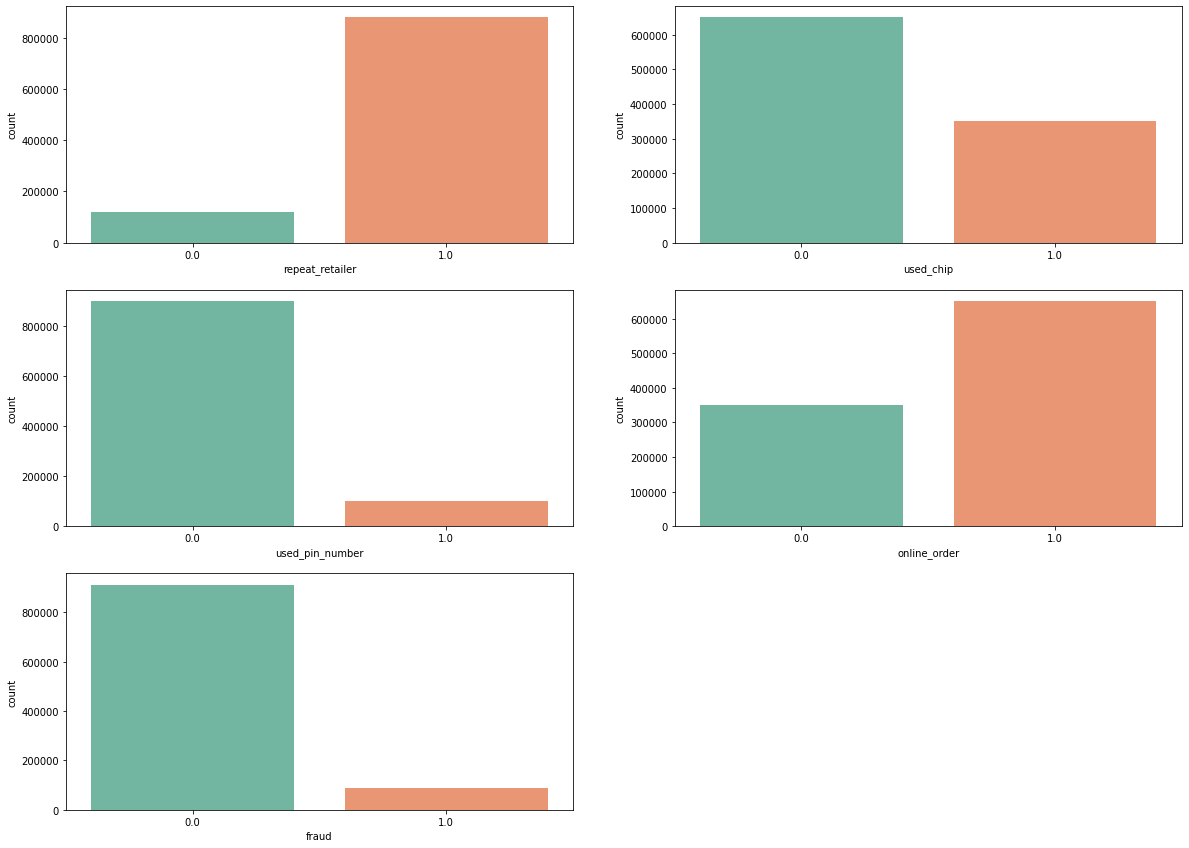

In [ ]:
plt.figure(figsize = (20,20))

plt.subplot(4,2,1)
sns.countplot(x = 'repeat_retailer', palette='Set2', data = df)

plt.subplot(4,2,2)
sns.countplot(x = 'used_chip', palette='Set2', data = df)

plt.subplot(4,2,3)
sns.countplot(x = 'used_pin_number', palette='Set2', data = df)

plt.subplot(4,2,4)
sns.countplot(x = 'online_order', palette='Set2', data = df)

plt.subplot(4,2,5)
sns.countplot(x = 'fraud', palette='Set2', data = df)

###Variabili continue

* `Distance from home`: Most of the time transitions are close to home.
* `Distance from last transition`: Most of the time transitions are close to the last transition.
* `Ratio to Median Purchase time`: Most of the time transitions are not much diferent than average

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot: xlabel='ratio_to_median_purchase_price'>

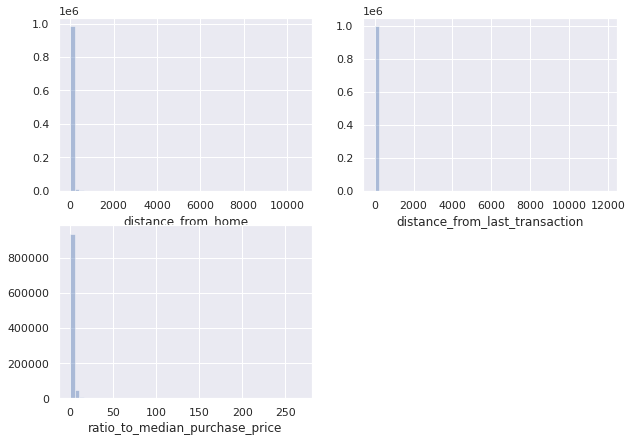

In [ ]:
plt.figure(figsize = (10,7))

sns.set(color_codes = True)

plt.subplot(2,2,1)
sns.distplot(df.distance_from_home, kde = False)

plt.subplot(2,2,2)
sns.distplot(df.distance_from_last_transaction, kde = False)

plt.subplot(2,2,3)
sns.distplot(df.ratio_to_median_purchase_price, kde = False)

###Grafico sbilanciamento

In [ ]:
labels=["Legit","Fraud"]

fraud_or_not = df["fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df['fraud'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"], title="Fraud vs Genuine transactions")
fig.show()

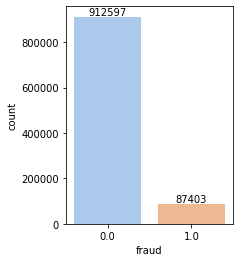

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud', data=df, palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

###Controllo outliers

In [ ]:
numeric_columns = (list(df.loc[:, 'distance_from_home':'fraud']))

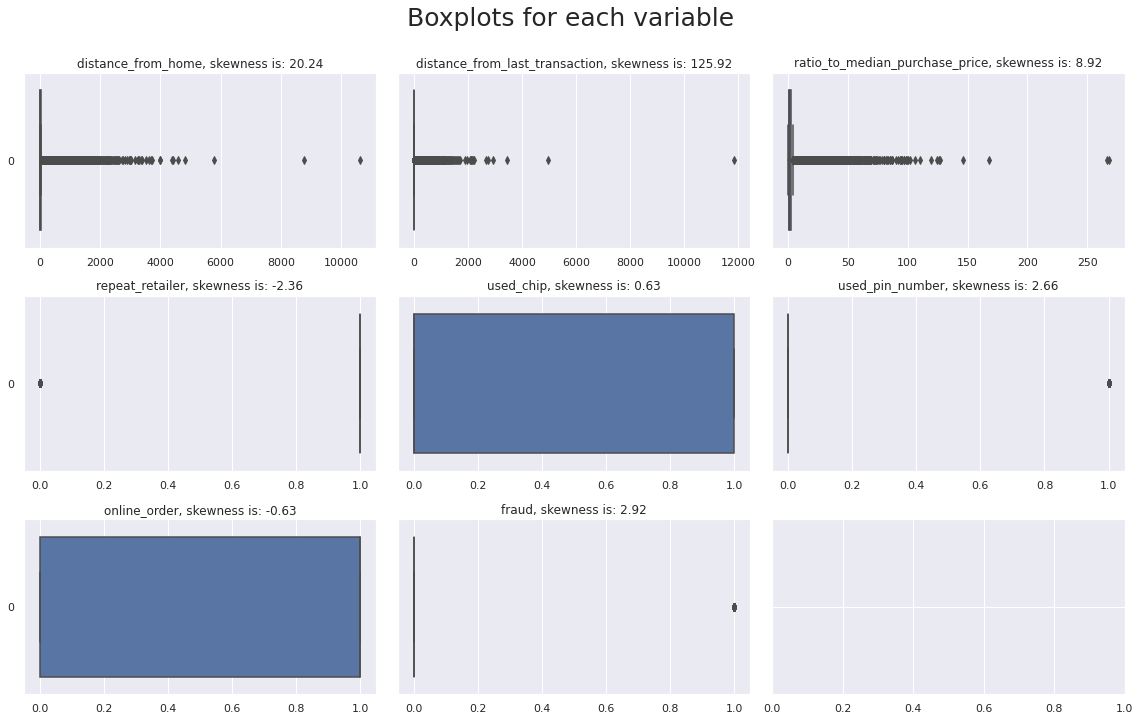

In [ ]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,10))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=3, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

####Inter Quartile Range (IQR)

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:

Find the first quartile, Q1.
Find the third quartile, Q3.
Calculate the IQR. IQR = Q3-Q1.
Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

In [ ]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 87403


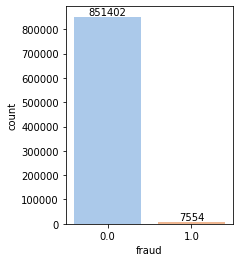

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fraud', data=df_out, palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

####Conclusion

We stayed with only 7554 fraud transactions in entire data frame!

We deleted almost all fraud transactions from a dataframe!
We have a few options here, but for that study we will just come back to the stage just before dropping outliers.

Occhio: in questo caso gli outliers non vanno eliminati ma utilizzati, le eccezioni sono proprio i casi che vogliamo analizzare e classificare.

Pertanto applichiamo tecniche che ne tengano conto (per l'oversampling soprattutto)

##Train test splitting stratificato

Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

####Aumentare/ridurre gli esempi prima o dopo lo splitting dei dati?

The rule of thumb is: never mess up with your test set. Always split into test and train sets BEFORE trying oversampling/undersampling techniques!

Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow model to simply memorize specific data points and cause overfitting and poor generalization to the test data. Data leakage can cause you to create overly optimistic if not completely invalid predictive models.

##BASELINE: Prove su dataframe originario

###Stratified k-Fold CV
The best model is not the one that gives accurate predictions on the training data, but the one which gives good predictions on the new data and avoids overfitting and underfitting.
The purpose of cross–validation is to test the ability of a machine learning model to predict new data.

Stratification is used when the datasets contain unbalanced classes. Therefore if we cross-validate with a normal technique it may produce subsamples that have a varying distribution of classes. Some unbalanced samples may produce exceptionally high scores leading to a high cross-validation score overall, which is undesirable. Therefore we create stratified subsamples that preserve the class frequencies in the individual folds to ensure that we are able to get a clear picture of the model performance.

###Oversample/undersample e Cross Validation
If you want to undersample or oversample your data you shouldn't do it before cross validating because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem.

Exactly like we should do feature selection inside the cross validation loop, we should also oversample inside the loop.

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)

In [ ]:
xgb = xg.XGBClassifier(n_estimators=100, max_depth = 3)

###Optimising for Recall
Recall: The ability of a model to find all the relevant cases within a data set. The number of true positives divided by the number of true positives plus the number of false negatives.

In most high-risk detection cases (like cancer), recall is a more important evaluation metric than precision.

In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed to genuine transaction, which is detrimental. In this use case, false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud.

Quando precision > recall 
Precision is more important than Recall when you would like to have less False Positives in trade off to have more False Negatives. Meaning, getting a False Positive is very costly, and a False Negative is not as much.

In [ ]:
knn_cv_score = cross_val_score(knn, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(knn_cv_score))
print("Average Cross Validation Recall score: {}".format(knn_cv_score.mean()))

Cross Validation Recall scores are: [0.92489376 0.92391304 0.91966329 0.92048705 0.91893438]
Average Cross Validation Recall score: 0.9215783030168876


In [ ]:
rf_cv_score = cross_val_score(rf, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(rf_cv_score))
print("Average Cross Validation Recall score: {}".format(rf_cv_score.mean()))

Cross Validation Recall scores are: [0.99975482 0.99991827 0.99983655 1.         0.99991828]
Average Cross Validation Recall score: 0.9998855848597479


In [ ]:
xgb_cv_score = cross_val_score(xgb, X, Y, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(xgb_cv_score))
print("Average Cross Validation Recall score: {}".format(xgb_cv_score.mean()))

Cross Validation Recall scores are: [0.99689441 0.99615888 0.99256293 0.9949334  0.99517856]
Average Cross Validation Recall score: 0.9951456339987652


###Hyperparameter Tuning Using GridSearchCV

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters. These can be tuned in different step.

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model as well as the parameters must be entered. After extracting the best parameter values, predictions are made.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that you included in your parameter grid.

GRADIENT DESCENT NEL GRIDSEARCH?
Lista parametri per i vari modelli

In [ ]:
#Parametri per il k-NN
knn_params = {
    'n_neighbors': list(range(5,10,1)),
    'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

In [ ]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 6, 10],
    'random_state': [13]
}

In [ ]:
#Parametri per l'XGBooster
xgb_params = {
    'learning_rate': [0.1,0.5,0.8,1],
    'max_depth': [2,5,10],
    'n_estimators' : [50,100]
}

###k-NN

In [ ]:
grid_knn = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_knn.best_params_)
print('Best score:', grid_knn.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.9445588800657431


In [ ]:
y_pred_grid_knn = grid_knn.predict(x_test)

In [ ]:
y_pred_train_grid_knn = grid_knn.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn)

grid_knn_Recall = recall_score(y_test, y_pred_grid_knn)
grid_knn_Precision = precision_score(y_test, y_pred_grid_knn)
grid_knn_f1 = f1_score(y_test, y_pred_grid_knn)
grid_knn_accuracy = accuracy_score(y_test, y_pred_grid_knn)

print(cm)

[[271522   2257]
 [  1327  24894]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_knn)

grid_train_knn_Recall = recall_score(Y, y_pred_train_grid_knn)
grid_train_knn_Precision = precision_score(Y, y_pred_train_grid_knn)
grid_train_knn_f1 = f1_score(Y, y_pred_train_grid_knn)
grid_train_knn_accuracy = accuracy_score(Y, y_pred_train_grid_knn)

print(cm)

[[635908   2910]
 [  1621  59561]]


In [ ]:
knn_ndf = [(grid_knn_Recall, grid_knn_Precision, grid_knn_f1, grid_knn_accuracy)]

grid_knn_score = pd.DataFrame(data=knn_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_score.insert(0, 'Model', 'k-NN')
grid_knn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN,0.949392,0.916872,0.932849,0.988053


In [ ]:
knn_train_ndf = [(grid_train_knn_Recall, grid_train_knn_Precision, grid_train_knn_f1, grid_train_knn_accuracy)]

grid_train_knn_score = pd.DataFrame(data=knn_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_score.insert(0, 'Model', 'k-NN_train')
grid_train_knn_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN_train,0.973505,0.953418,0.963357,0.993527


###Random Forest

In [ ]:
grid_rf = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 13}
Best score: 0.9998365492271881


In [ ]:
y_pred_grid_rf = grid_rf.predict(x_test)

In [ ]:
y_pred_train_grid_rf = grid_rf.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf)

grid_rf_Recall = recall_score(y_test, y_pred_grid_rf)
grid_rf_Precision = precision_score(y_test, y_pred_grid_rf)
grid_rf_f1 = f1_score(y_test, y_pred_grid_rf)
grid_rf_accuracy = accuracy_score(y_test, y_pred_grid_rf)

print(cm)

[[273779      0]
 [     1  26220]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_rf)

grid_train_rf_Recall = recall_score(Y, y_pred_train_grid_rf)
grid_train_rf_Precision = precision_score(Y, y_pred_train_grid_rf)
grid_train_rf_f1 = f1_score(Y, y_pred_train_grid_rf)
grid_train_rf_accuracy = accuracy_score(Y, y_pred_train_grid_rf)

print(cm)

[[638818      0]
 [     0  61182]]


In [ ]:
grid_rf_ndf = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_rf_score = pd.DataFrame(data = grid_rf_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_score.insert(0, 'Model', 'rf')
grid_rf_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf,0.999962,1.0,0.999981,0.999997


In [ ]:
grid_train_rf_ndf = [(grid_train_rf_Recall, grid_train_rf_Precision, grid_train_rf_f1, grid_train_rf_accuracy)]

grid_train_rf_score = pd.DataFrame(data=grid_train_rf_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_score.insert(0, 'Model', 'rf_test')
grid_train_rf_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf_test,1.0,1.0,1.0,1.0


###XGBooster
XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm.

It is an ensemble of decision trees algorithm where new trees fix errors of those trees that are already part of the model. Trees are added until no further improvements can be made to the model.

In [ ]:
grid_xgb = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_xgb.best_params_)
print('Best score:', grid_xgb.best_score_)

Best parameters: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.9998855861954684


In [ ]:
y_pred_grid_xgb = grid_xgb.predict(x_test)

In [ ]:
y_pred_train_grid_xgb = grid_xgb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb)

grid_xgb_Recall = recall_score(y_test, y_pred_grid_xgb)
grid_xgb_Precision = precision_score(y_test, y_pred_grid_xgb)
grid_xgb_f1 = f1_score(y_test, y_pred_grid_xgb)
grid_xgb_accuracy = accuracy_score(y_test, y_pred_grid_xgb)

print(cm)

[[273779      0]
 [     2  26219]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_xgb)

grid_train_xgb_Recall = recall_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_Precision = precision_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_f1 = f1_score(Y, y_pred_train_grid_xgb)
grid_train_xgb_accuracy = accuracy_score(Y, y_pred_train_grid_xgb)

print(cm)

[[638818      0]
 [     0  61182]]


In [ ]:
grid_xgb_ndf = [(grid_xgb_Recall, grid_xgb_Precision, grid_xgb_f1, grid_xgb_accuracy)]

grid_xgb_score = pd.DataFrame(data = grid_xgb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_score.insert(0, 'Model', 'xgb')
grid_xgb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb,0.999924,1.0,0.999962,0.999993


In [ ]:
grid_train_xgb_ndf = [(grid_train_xgb_Recall, grid_train_xgb_Precision, grid_train_xgb_f1, grid_train_xgb_accuracy)]

grid_train_xgb_score = pd.DataFrame(data=grid_train_xgb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_score.insert(0, 'Model', 'xgb_test')
grid_train_xgb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_test,1.0,1.0,1.0,1.0


####Performance comparison



In [ ]:
predictions = pd.concat([grid_knn_score, grid_rf_score, grid_xgb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
1,rf,0.999962,1.000000,0.999981,0.999997
2,xgb,0.999924,1.000000,0.999962,0.999993
0,k-NN,0.949392,0.916872,0.932849,0.988053


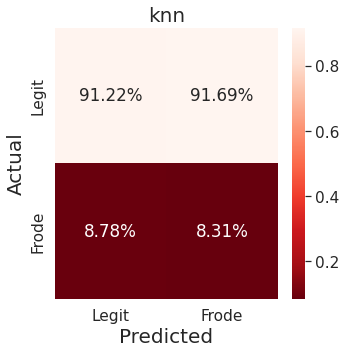

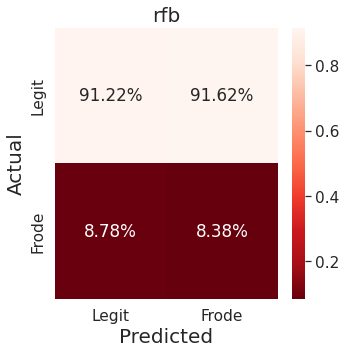

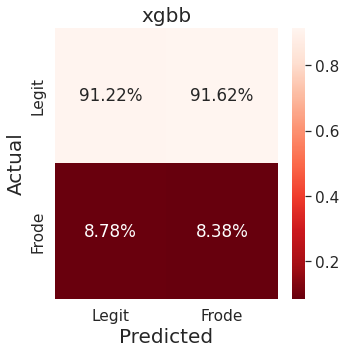

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn,'knn')
confusionMatrix(y_test, y_pred_grid_rf,'rfb')
confusionMatrix(y_test, y_pred_grid_xgb,'xgbb')

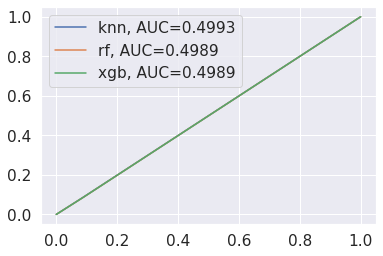

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn), 4)
plt.plot(fpr,tpr,label="knn, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf )
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf ), 4)
plt.plot(fpr,tpr,label="rf, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb )
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb ), 4)
plt.plot(fpr,tpr,label="xgb, AUC="+str(auc))

#add legend
plt.legend()

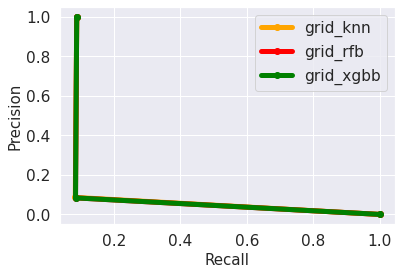

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn)
plt.plot(precision, recall, marker='o', label='grid_knn',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()


precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf)
plt.plot(precision, recall, marker='o', label='grid_rfb',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb)
plt.plot(precision, recall, marker='o', label='grid_xgbb',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

##Class weights in the models
Most of the machine learning models provide a parameter called `class_weights`.

###Balanced Random Forest

In [ ]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [ ]:
grid_rfb = GridSearchCV(rfb, param_grid=rf_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
y_pred_grid_rfb = grid_rfb.predict(x_test)

In [ ]:
y_pred_train_grid_rfb = grid_rfb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rfb)

grid_rfb_Recall = recall_score(y_test, y_pred_grid_rfb)
grid_rfb_Precision = precision_score(y_test, y_pred_grid_rfb)
grid_rfb_f1 = f1_score(y_test, y_pred_grid_rfb)
grid_rfb_accuracy = accuracy_score(y_test, y_pred_grid_rfb)

print(cm)

[[272581   1198]
 [     2  26219]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_rfb)

grid_train_rfb_Recall = recall_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_Precision = precision_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_f1 = f1_score(Y, y_pred_train_grid_rfb)
grid_train_rfb_accuracy = accuracy_score(Y, y_pred_train_grid_rfb)

print(cm)

[[636004   2814]
 [     0  61182]]


In [ ]:
grid_rfb_ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = grid_rfb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Model', 'rfb')
grid_rfb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rfb,0.999924,0.956304,0.977628,0.996


In [ ]:
grid_train_rfb_ndf = [(grid_train_rfb_Recall, grid_train_rfb_Precision, grid_train_rfb_f1, grid_train_rfb_accuracy)]

grid_train_rfb_score = pd.DataFrame(data=grid_train_rfb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rfb_score.insert(0, 'Model', 'rf_train')
grid_train_rfb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,rf_train,1.0,0.956029,0.97752,0.99598


###Balanced k-NN

In principal, unbalanced classes are not a problem at all for the k-nearest neighbor algorithm.

Because the algorithm is not influenced in any way by the size of the class, it will not favor any on the basis of size. Try to run k-means with an obvious outlier and k+1 and you will see that most of the time the outlier will get its own class.

Of course, with hard datasets it is always advisable to run the algorithm multiple times. This is to avoid trouble due to a bad initialization.

### Balanced XGBooster
The XGBoost algorithm offers a large number of hyperparameters, many of which require tuning in order to get the most out of the algorithm on a given dataset.

The implementation provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems; this is the `scale_pos_weight` hyperparameter.

The scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. 



In [ ]:
#definire il valore di scale_pos_weight  sum(negative instances) / sum(positive instances)
legit_instances = 0
fraud_instances = 0
for i in range(0, df.shape[0]):
  if df['fraud'][i] == 0.0:
    legit_instances = legit_instances + 1
  else:
    fraud_instances = fraud_instances + 1

In [ ]:
legit_weight = fraud_instances/legit_instances
legit_weight

0.09577392868922427

In [ ]:
xgbb = xg.XGBClassifier(n_estimators=100, max_depth = 3, scale_pos_weight=legit_weight)

In [ ]:
grid_xgbb = GridSearchCV(xgbb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X, Y)

In [ ]:
print('Best parameters:', grid_xgbb.best_params_)
print('Best score:', grid_xgbb.best_score_)

Best parameters: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.9998365532343495


In [ ]:
y_pred_grid_xgbb = grid_xgbb.predict(x_test)

In [ ]:
y_pred_train_grid_xgbb = grid_xgbb.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgbb)

grid_xgbb_Recall = recall_score(y_test, y_pred_grid_xgbb)
grid_xgbb_Precision = precision_score(y_test, y_pred_grid_xgbb)
grid_xgbb_f1 = f1_score(y_test, y_pred_grid_xgbb)
grid_xgbb_accuracy = accuracy_score(y_test, y_pred_grid_xgbb)

print(cm)

[[273779      0]
 [     2  26219]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_grid_xgbb)

grid_train_xgbb_Recall = recall_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_Precision = precision_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_f1 = f1_score(Y, y_pred_train_grid_xgbb)
grid_train_xgbb_accuracy = accuracy_score(Y, y_pred_train_grid_xgbb)

print(cm)

[[638818      0]
 [     1  61181]]


In [ ]:
grid_xgbb_ndf = [(grid_xgbb_Recall, grid_xgbb_Precision, grid_xgbb_f1, grid_xgbb_accuracy)]

grid_xgbb_score = pd.DataFrame(data = grid_xgbb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgbb_score.insert(0, 'Model', 'xgbb')
grid_xgbb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgbb,0.999924,1.0,0.999962,0.999993


In [ ]:
grid_train_xgbb_ndf = [(grid_train_xgbb_Recall, grid_train_xgbb_Precision, grid_train_xgbb_f1, grid_train_xgbb_accuracy)]

grid_train_xgbb_score = pd.DataFrame(data=grid_train_xgbb_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgbb_score.insert(0, 'Model', 'xgbb_train')
grid_train_xgbb_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgbb_train,0.999984,1.0,0.999992,0.999999


####Confronto Performance

In [ ]:
predictions = pd.concat([grid_rfb_score, grid_xgbb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,rfb,0.999924,0.956304,0.977628,0.996000
1,xgbb,0.999924,1.000000,0.999962,0.999993


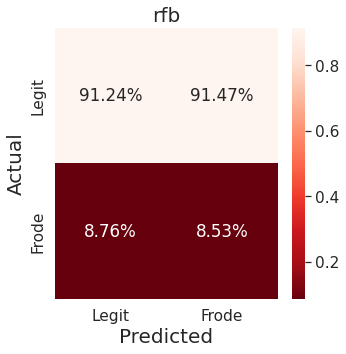

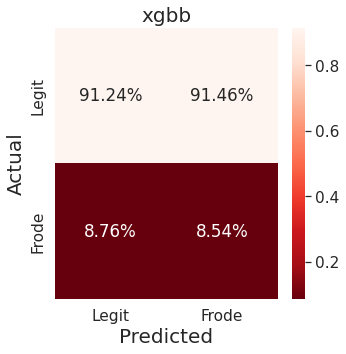

In [ ]:
confusionMatrix(y_test, y_pred_grid_rfb,'rfb')
confusionMatrix(y_test, y_pred_grid_xgbb,'xgbb')

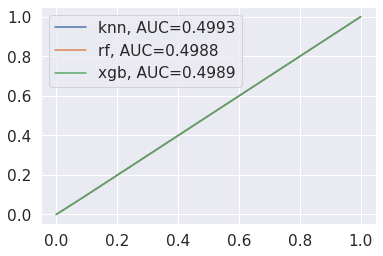

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rfb)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rfb), 4)
plt.plot(fpr,tpr,label="rf, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgbb)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgbb), 4)
plt.plot(fpr,tpr,label="xgb, AUC="+str(auc))
#add legend
plt.legend()

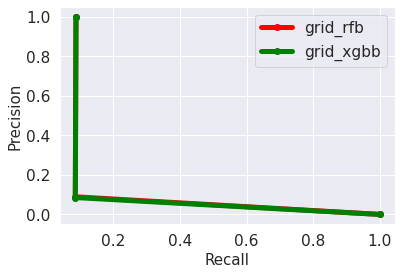

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rfb)
plt.plot(precision, recall, marker='o', label='grid_rfb',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgbb)
plt.plot(precision, recall, marker='o', label='grid_xgbb',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

##Random Undersampling Imbalanced Datasets

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This approach may be more suitable for those datasets where there is a class imbalance although a sufficient number of examples in the minority class, such a useful model can be fit.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
# define undersampling strategy
rus = RandomUnderSampler(random_state=42)

In [ ]:
# fit and apply the transform
X_under, Y_under = rus.fit_resample(X, Y)

In [ ]:
print('Legit:', Y_under.value_counts()[0], '/', round(Y_under.value_counts()[0]/len(Y_under) * 100,2), '% of the dataset')
print('Frauds:', Y_under.value_counts()[1], '/',round(Y_under.value_counts()[1]/len(Y_under) * 100,2), '% of the dataset')

Legit: 61182 / 50.0 % of the dataset
Frauds: 61182 / 50.0 % of the dataset


Ci restano abbastanza dati da poter provare il training dei modelli.

###K-NN sul dataset ridotto

In [ ]:
grid_knn_under = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_knn_under.best_params_)
print('Best score:', grid_knn_under.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 9}
Best score: 0.9990193180703766


In [ ]:
y_pred_grid_knn_under = grid_knn_under.predict(x_test)

In [ ]:
y_pred_train_grid_knn_under = grid_knn_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn_under)

grid_knn_under_Recall = recall_score(y_test, y_pred_grid_knn_under)
grid_knn_under_Precision = precision_score(y_test, y_pred_grid_knn_under)
grid_knn_under_f1 = f1_score(y_test, y_pred_grid_knn_under)
grid_knn_under_accuracy = accuracy_score(y_test, y_pred_grid_knn_under)

print(cm)

[[253816  19963]
 [    12  26209]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_knn_under)

grid_train_knn_under_Recall = recall_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_Precision = precision_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_f1 = f1_score(Y_under, y_pred_train_grid_knn_under)
grid_train_knn_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_knn_under)

print(cm)

[[57124  4058]
 [   31 61151]]


In [ ]:
grid_knn_under_ndf = [(grid_knn_under_Recall, grid_knn_under_Precision, grid_knn_under_f1, grid_knn_under_accuracy)]

grid_knn_under_score = pd.DataFrame(data=grid_knn_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_under_score.insert(0, 'Model', 'grid_k-NN_under')
grid_knn_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_under,0.999542,0.567638,0.724076,0.933417


In [ ]:
grid_train_knn_under_ndf = [(grid_train_knn_under_Recall, grid_train_knn_under_Precision, grid_train_knn_under_f1, grid_train_knn_under_accuracy)]

grid_train_knn_under_score = pd.DataFrame(data=grid_train_knn_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_under_score.insert(0, 'Model', 'k-NN_train')
grid_train_knn_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,k-NN_train,0.999493,0.937769,0.967648,0.966583


###Random Forest su dataset ridotto

In [ ]:
grid_rf_under = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_rf_under.best_params_)
print('Best score:', grid_rf_under.best_score_)

Best parameters: {'max_depth': 4, 'n_estimators': 200, 'random_state': 13}
Best score: 1.0


In [ ]:
y_pred_grid_rf_under = grid_rf_under.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
y_pred_train_grid_rf_under = grid_rf_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf_under)

grid_rf_under_Recall = recall_score(y_test, y_pred_grid_rf_under)
grid_rf_under_Precision = precision_score(y_test, y_pred_grid_rf_under)
grid_rf_under_f1 = f1_score(y_test, y_pred_grid_rf_under)
grid_rf_under_accuracy = accuracy_score(y_test, y_pred_grid_rf_under)

print(cm)

[[271077   2702]
 [ 19997   6224]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_rf_under)

grid_train_rf_under_Recall = recall_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_Precision = precision_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_f1 = f1_score(Y_under, y_pred_train_grid_rf_under)
grid_train_rf_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_rf_under)

print(cm)

[[60940   242]
 [    0 61182]]


In [ ]:
grid_rf_under_ndf = [(grid_rf_under_Recall, grid_rf_under_Precision, grid_rf_under_f1, grid_rf_under_accuracy)]

grid_rf_under_score = pd.DataFrame(data=grid_rf_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_under_score.insert(0, 'Model', 'grid_rf_under')
grid_rf_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_rf_under,0.237367,0.697289,0.35417,0.924337


In [ ]:
grid_train_rf_under_ndf = [(grid_train_rf_under_Recall, grid_train_rf_under_Precision, grid_train_rf_under_f1, grid_train_rf_under_accuracy)]

grid_train_rf_under_score = pd.DataFrame(data=grid_train_rf_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_under_score.insert(0, 'Model', 'grid_train_rf_under')
grid_train_rf_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_rf_under,1.0,0.99606,0.998026,0.998022


###XGB su dataset ridotto

In [ ]:
grid_xgb_under = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X_under, Y_under)

In [ ]:
print('Best parameters:', grid_xgb_under.best_params_)
print('Best score:', grid_xgb_under.best_score_)

Best parameters: {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 50}
Best score: 0.999967310914014


In [ ]:
y_pred_grid_xgb_under = grid_xgb_under.predict(x_test)

In [ ]:
y_pred_train_grid_xgb_under = grid_xgb_under.predict(X_under)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb_under)

grid_xgb_under_Recall = recall_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_Precision = precision_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_f1 = f1_score(y_test, y_pred_grid_xgb_under)
grid_xgb_under_accuracy = accuracy_score(y_test, y_pred_grid_xgb_under)

print(cm)

[[249836  23943]
 [ 23914   2307]]


In [ ]:
cm = confusion_matrix(Y_under, y_pred_train_grid_xgb_under)

grid_train_xgb_under_Recall = recall_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_Precision = precision_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_f1 = f1_score(Y_under, y_pred_train_grid_xgb_under)
grid_train_xgb_under_accuracy = accuracy_score(Y_under, y_pred_train_grid_xgb_under)

print(cm)

[[61180     2]
 [    0 61182]]


In [ ]:
grid_xgb_under_ndf = [(grid_xgb_under_Recall, grid_xgb_under_Precision, grid_xgb_under_f1, grid_xgb_under_accuracy)]

grid_xgb_under_score = pd.DataFrame(data = grid_xgb_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_under_score.insert(0, 'Model', 'xgb_under')
grid_xgb_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_under,0.087983,0.087886,0.087934,0.840477


In [ ]:
grid_train_xgb_under_ndf = [(grid_train_xgb_under_Recall, grid_train_xgb_under_Precision, grid_train_xgb_under_f1, grid_train_xgb_under_accuracy)]

grid_train_xgb_under_score = pd.DataFrame(data=grid_train_xgb_under_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_under_score.insert(0, 'Model', 'xgb_train_under')
grid_train_xgb_under_score

,Model,Recall,Precision,F1 Score,Accuracy
0,xgb_train_under,1.0,0.999967,0.999984,0.999984


###Confronto Performance

In [ ]:
predictions = pd.concat([grid_knn_under_score, grid_rf_under_score, grid_xgb_under_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_under,0.999542,0.567638,0.724076,0.933417
1,grid_rf_under,0.237367,0.697289,0.354170,0.924337
2,xgb_under,0.087983,0.087886,0.087934,0.840477


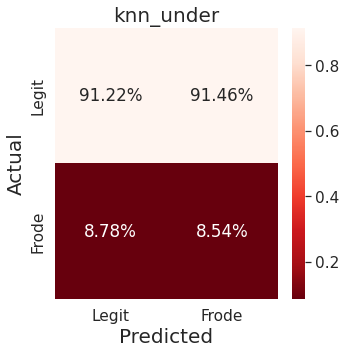

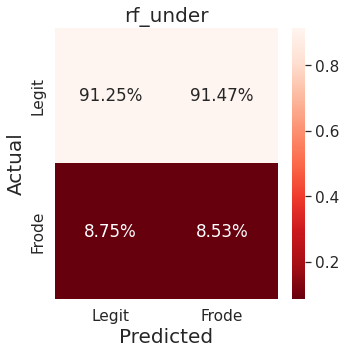

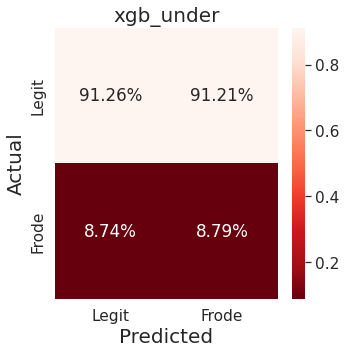

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn_under,'knn_under')
confusionMatrix(y_test, y_pred_grid_rf_under,'rf_under')
confusionMatrix(y_test, y_pred_grid_xgb_under,'xgb_under')

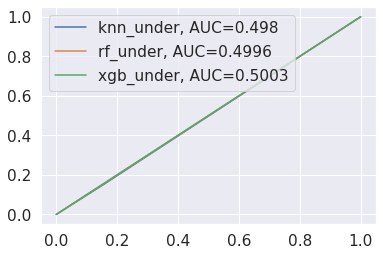

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn_under), 4)
plt.plot(fpr,tpr,label="knn_under, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf_under), 4)
plt.plot(fpr,tpr,label="rf_under, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb_under)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb_under), 4)
plt.plot(fpr,tpr,label="xgb_under, AUC="+str(auc))
#add legend
plt.legend()

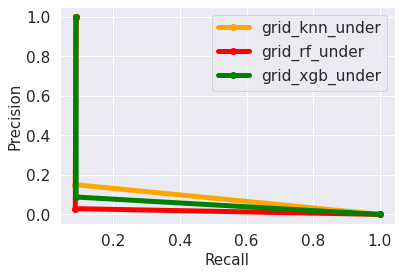

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn_under)
plt.plot(precision, recall, marker='o', label='grid_knn_under',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf_under)
plt.plot(precision, recall, marker='o', label='grid_rf_under',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb_under)
plt.plot(precision, recall, marker='o', label='grid_xgb_under',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

##Random Oversampling
The random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples. Let's say every data point from the minority class is copied 6 times before making the splits. If we did a 3-fold validation, each fold has (on average) 2 copies of each point! In this way a classifier might construct rules that are apparently accurate, but actually cover one replicated example.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [ ]:
# fit and apply the transform
X_over, Y_over = ros.fit_resample(X, Y)

In [ ]:
print('Legit:', Y_over.value_counts()[0], '/', round(Y_over.value_counts()[0]/len(Y_over) * 100,2), '% of the dataset')
print('Frauds:', Y_over.value_counts()[1], '/',round(Y_over.value_counts()[1]/len(Y_over) * 100,2), '% of the dataset')

Legit: 638818 / 50.0 % of the dataset
Frauds: 638818 / 50.0 % of the dataset


###k-NN su dataset esteso

In [ ]:
grid_knn_over = GridSearchCV(knn, param_grid=knn_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_knn_over.best_params_)
print('Best score:', grid_knn_over.best_score_)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5}
Best score: 0.9999561690644156


In [ ]:
y_pred_grid_knn_over = grid_knn_over.predict(x_test)

In [ ]:
y_pred_train_grid_knn_over = grid_knn_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_knn_over)

grid_knn_over_Recall = recall_score(y_test, y_pred_grid_knn_over)
grid_knn_over_Precision = precision_score(y_test, y_pred_grid_knn_over)
grid_knn_over_f1 = f1_score(y_test, y_pred_grid_knn_over)
grid_knn_over_accuracy = accuracy_score(y_test, y_pred_grid_knn_over)

print(cm)

[[268831   4948]
 [    70  26151]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_knn_over)

grid_train_knn_over_Recall = recall_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_Precision = precision_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_f1 = f1_score(Y_over, y_pred_train_grid_knn_over)
grid_train_knn_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_knn_over)

print(cm)

[[628576  10242]
 [     0 638818]]


In [ ]:
grid_knn_over_ndf = [(grid_knn_over_Recall, grid_knn_over_Precision, grid_knn_over_f1, grid_knn_over_accuracy)]

grid_knn_over_score = pd.DataFrame(data=grid_knn_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_knn_over_score.insert(0, 'Model', 'grid_k-NN_over')
grid_knn_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_over,0.99733,0.840895,0.912456,0.983273


In [ ]:
grid_train_knn_over_ndf = [(grid_train_knn_over_Recall, grid_train_knn_over_Precision, grid_train_knn_over_f1, grid_train_knn_over_accuracy)]

grid_train_knn_over_score = pd.DataFrame(data=grid_train_knn_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_knn_over_score.insert(0, 'Model', 'grid_k-NN_over_train')
grid_train_knn_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_k-NN_over_train,1.0,0.98422,0.992047,0.991984


###Random Forest su dataset esteso

In [ ]:
grid_rf_over = GridSearchCV(rf, param_grid=rf_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_rf_over.best_params_)
print('Best score:', grid_rf_over.best_score_)

Best parameters: {'max_depth': 4, 'n_estimators': 100, 'random_state': 13}
Best score: 1.0


In [ ]:
y_pred_grid_rf_over = grid_rf_over.predict(x_test)

In [ ]:
y_pred_train_grid_rf_over = grid_rf_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_rf_over)

grid_rf_over_Recall = recall_score(y_test, y_pred_grid_rf_over)
grid_rf_over_Precision = precision_score(y_test, y_pred_grid_rf_over)
grid_rf_over_f1 = f1_score(y_test, y_pred_grid_rf_over)
grid_rf_over_accuracy = accuracy_score(y_test, y_pred_grid_rf_over)

print(cm)

[[272659   1120]
 [     2  26219]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_rf_over)

grid_train_rf_over_Recall = recall_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_Precision = precision_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_f1 = f1_score(Y_over, y_pred_train_grid_rf_over)
grid_train_rf_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_rf_over)

print(cm)

[[636177   2641]
 [     0 638818]]


In [ ]:
grid_rf_over_ndf = [(grid_rf_over_Recall, grid_rf_over_Precision, grid_rf_over_f1, grid_rf_over_accuracy)]

grid_rf_over_score = pd.DataFrame(data=grid_rf_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rf_over_score.insert(0, 'Model', 'grid_rf_over')
grid_rf_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_rf_over,0.999924,0.959033,0.979052,0.99626


In [ ]:
grid_train_rf_over_ndf = [(grid_train_rf_over_Recall, grid_train_rf_over_Precision, grid_train_rf_over_f1, grid_train_rf_over_accuracy)]

grid_train_rf_over_score = pd.DataFrame(data=grid_train_rf_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_rf_over_score.insert(0, 'Model', 'grid_train_rf_over')
grid_train_rf_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_rf_over,1.0,0.995883,0.997937,0.997933


###XGB su dataset esteso

In [ ]:
grid_xgb_over = GridSearchCV(xgb, param_grid=xgb_params, cv=kf, scoring='recall').fit(X_over, Y_over)

In [ ]:
print('Best parameters:', grid_xgb_over.best_params_)
print('Best score:', grid_xgb_over.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best score: 1.0


In [ ]:
y_pred_grid_xgb_over = grid_xgb_over.predict(x_test)

In [ ]:
y_pred_train_grid_xgb_over = grid_xgb_over.predict(X_over)

In [ ]:
cm = confusion_matrix(y_test, y_pred_grid_xgb_over)

grid_xgb_over_Recall = recall_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_Precision = precision_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_f1 = f1_score(y_test, y_pred_grid_xgb_over)
grid_xgb_over_accuracy = accuracy_score(y_test, y_pred_grid_xgb_over)

print(cm)

[[273778      1]
 [     0  26221]]


In [ ]:
cm = confusion_matrix(Y_over, y_pred_train_grid_xgb_over)

grid_train_xgb_over_Recall = recall_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_Precision = precision_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_f1 = f1_score(Y_over, y_pred_train_grid_xgb_over)
grid_train_xgb_over_accuracy = accuracy_score(Y_over, y_pred_train_grid_xgb_over)

print(cm)

[[638818      0]
 [     0 638818]]


In [ ]:
grid_xgb_over_ndf = [(grid_xgb_over_Recall, grid_xgb_over_Precision, grid_xgb_over_f1, grid_xgb_over_accuracy)]

grid_xgb_over_score = pd.DataFrame(data=grid_xgb_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_xgb_over_score.insert(0, 'Model', 'grid_xgb_over')
grid_xgb_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_xgb_over,1.0,0.999962,0.999981,0.999997


In [ ]:
grid_train_xgb_over_ndf = [(grid_train_xgb_over_Recall, grid_train_xgb_over_Precision, grid_train_xgb_over_f1, grid_train_xgb_over_accuracy)]

grid_train_xgb_over_score = pd.DataFrame(data=grid_train_xgb_over_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_train_xgb_over_score.insert(0, 'Model', 'grid_train_xgb_over')
grid_train_xgb_over_score

,Model,Recall,Precision,F1 Score,Accuracy
0,grid_train_xgb_over,1.0,1.0,1.0,1.0


###Confronto Performance

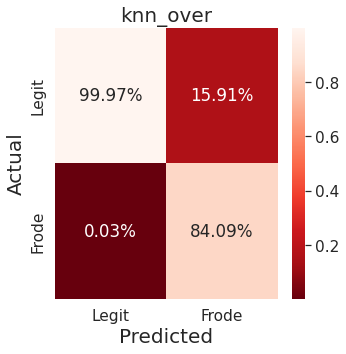

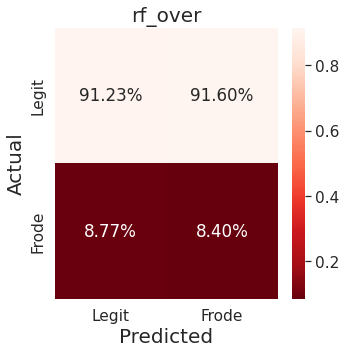

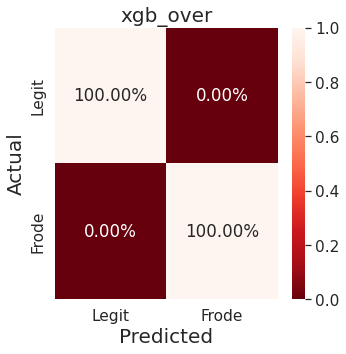

In [ ]:
predictions = pd.concat([grid_knn_over_score, grid_rf_over_score, grid_xgb_over_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

confusionMatrix(y_test, y_pred_grid_knn_over,'knn_over')
confusionMatrix(y_test, y_pred_grid_rf_over,'rf_over')
confusionMatrix(y_test, y_pred_grid_xgb_over,'xgb_over')

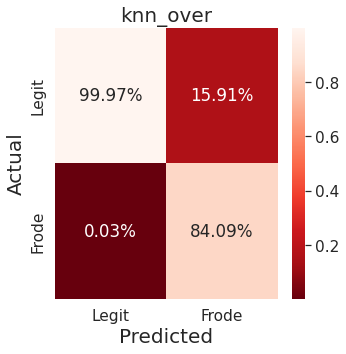

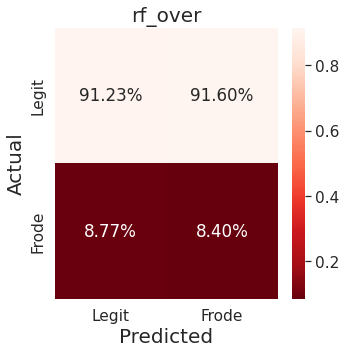

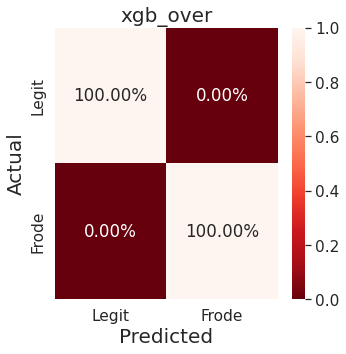

In [ ]:
confusionMatrix(y_test, y_pred_grid_knn_over,'knn_over')
confusionMatrix(y_test, y_pred_grid_rf_over,'rf_over')
confusionMatrix(y_test, y_pred_grid_xgb_over,'xgb_over')

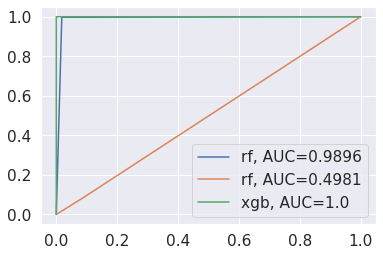

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_knn_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_knn_over), 4)
plt.plot(fpr,tpr,label="knn_over, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_rf_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_rf_over), 4)
plt.plot(fpr,tpr,label="rf_over, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_grid_xgb_over)
auc = round(metrics.roc_auc_score(y_test, y_pred_grid_xgb_over), 4)
plt.plot(fpr,tpr,label="xgb_over, AUC="+str(auc))
#add legend
plt.legend()

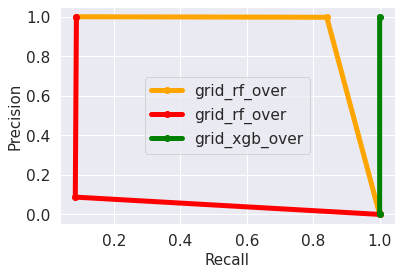

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_knn_over)
plt.plot(precision, recall, marker='o', label='grid_rf_over',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_rf_over)
plt.plot(precision, recall, marker='o', label='grid_rf_over',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_grid_xgb_over)
plt.plot(precision, recall, marker='o', label='grid_xgb_over',color='green',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

##Apprendimento Probabilistico e Feature Scaling
We will run the models before scaling the data, after we will back here to run the StandardScaler and MinMax Scaler and verify if we have best results using the scaling.

###Feature scaling

Preferisco lo standard scaler al robust scaler in quanto mi interessa considerare gli outliers???

Questo sito (https://proclusacademy.com/blog/robust-scaler-outliers/#:~:text=Standard%20scaling%20uses%20mean%20and,interquartile%20range%20(IQR)%20instead.&text=The%20scaled%20values%20will%20have,makes%20it%20resistant%20to%20outliers) dice:
Outliers can significantly affect statistics such as mean and standard deviation. Therefore, you may want to avoid using the standard scaling when the input has outliers.

We should use robust scaling instead. It uses median and interquartile range (IQR) to scale input values. Both of these statistics are resistant to outliers. That’s why robust scaling is immune to the adverse influence of outliers.

Il RobustScaler utilizza la mediana e il quartile invece della media e della deviazione standard per calcolare la scala dei dati. Ciò lo rende più resistente ai valori anomali o fuori scala (chiamati anche "outlier") che potrebbero influire sulle prestazioni di alcuni algoritmi di apprendimento automatico.
Il robust scaler è particolarmente utile quando si lavora con dati che contengono molti valori anomali o fuori scala. In questi casi, la deviazione standard potrebbe non essere una rappresentazione accurata della scala dei dati, e utilizzare la mediana e il quartile per la normalizzazione può dare risultati migliori.

---
Quello su kaggle usa lo standard scaler 
(io provo entrambi)





###Standard Scaler

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
X_standard = scaler.fit_transform(X)

In [ ]:
X_standard[0]

array([ 0.47788202, -0.18284892,  0.04349141,  0.36658372,  1.36157608,
       -0.33445812, -1.36442519])

In [ ]:
X, x_test, Y, y_test = train_test_split(X_standard, Y, stratify=Y, test_size = 0.3)

####Training di Naive Bayes con Standard Scaler

In [ ]:
nbs = GaussianNB()
nbs.fit(X, Y)

GaussianNB()

In [ ]:
y_pred_nbs = nbs.predict(x_test)

In [ ]:
y_pred_train_nbs = nbs.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_nbs)

nbs_Recall = recall_score(y_test, y_pred_nbs)
nbs_Precision = precision_score(y_test, y_pred_nbs)
nbs_f1 = f1_score(y_test, y_pred_nbs)
nbs_accuracy = accuracy_score(y_test, y_pred_nbs)

print(cm)

[[269801   3978]
 [ 10350  15871]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_nbs)

nbs_train_Recall = recall_score(Y, y_pred_train_nbs)
nbs_train_Precision = precision_score(Y, y_pred_train_nbs)
nbs_train_f1 = f1_score(Y, y_pred_train_nbs)
nbs_train_accuracy = accuracy_score(Y, y_pred_train_nbs)

print(cm)

[[629331   9487]
 [ 23874  37308]]


In [ ]:
nbs_ndf = [(nbs_Recall, nbs_Precision, nbs_f1, nbs_accuracy)]

nbs_score = pd.DataFrame(data=nbs_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbs_score.insert(0, 'Model', 'nbs')
nbs_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbs,0.605278,0.799587,0.688995,0.95224


In [ ]:
nbs_train_ndf = [(nbs_train_Recall, nbs_train_Precision, nbs_train_f1, nbs_train_accuracy)]

nbs_train_score = pd.DataFrame(data=nbs_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbs_train_score.insert(0, 'Model', 'nbs_train')
nbs_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbs_train,0.609787,0.797265,0.691036,0.952341


###Robust Scaler

In [ ]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
scaler = RobustScaler()

In [ ]:
X_robust = scaler.fit_transform(X)

In [ ]:
X_robust[0]

array([ 2.19107961, -0.2247443 ,  0.58507116,  0.        ,  1.        ,
        0.        , -1.        ])

In [ ]:
X, x_test, Y, y_test = train_test_split(X_robust, Y, stratify=Y, test_size = 0.3)

####Training della Naive Bayes con Robust Scaler

In [ ]:
nbr = GaussianNB()
nbr.fit(X, Y)

GaussianNB()

In [ ]:
y_pred_nbr = nbr.predict(x_test)

In [ ]:
y_pred_train_nbr = nbr.predict(X)

In [ ]:
cm = confusion_matrix(y_test, y_pred_nbr)

nbr_Recall = recall_score(y_test, y_pred_nbr)
nbr_Precision = precision_score(y_test, y_pred_nbr)
nbr_f1 = f1_score(y_test, y_pred_nbr)
nbr_accuracy = accuracy_score(y_test, y_pred_nbr)

print(cm)

[[269559   4220]
 [ 10483  15738]]


In [ ]:
cm = confusion_matrix(Y, y_pred_train_nbr)

nbr_train_Recall = recall_score(Y, y_pred_train_nbr)
nbr_train_Precision = precision_score(Y, y_pred_train_nbr)
nbr_train_f1 = f1_score(Y, y_pred_train_nbr)
nbr_train_accuracy = accuracy_score(Y, y_pred_train_nbr)

print(cm)

[[629173   9645]
 [ 24363  36819]]


In [ ]:
nbr_ndf = [(nbr_Recall, nbr_Precision, nbr_f1, nbr_accuracy)]

nbr_score = pd.DataFrame(data=nbr_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbr_score.insert(0, 'Model', 'nbr')
nbr_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbr,0.600206,0.788556,0.681609,0.95099


In [ ]:
nbr_train_ndf = [(nbr_train_Recall, nbr_train_Precision, nbr_train_f1, nbr_train_accuracy)]

nbr_train_score = pd.DataFrame(data=nbr_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
nbr_train_score.insert(0, 'Model', 'nbr_train')
nbr_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,nbr_train,0.601795,0.79242,0.684076,0.951417


###Confronto Performance

In [ ]:
predictions = pd.concat([nbs_score, nbr_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
0,nbs,0.605278,0.799587,0.688995,0.95224
1,nbr,0.600206,0.788556,0.681609,0.95099


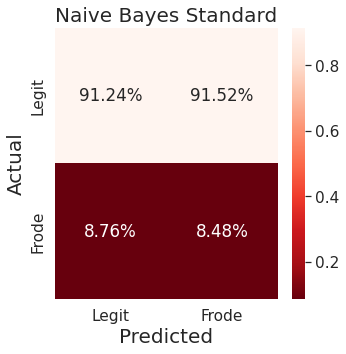

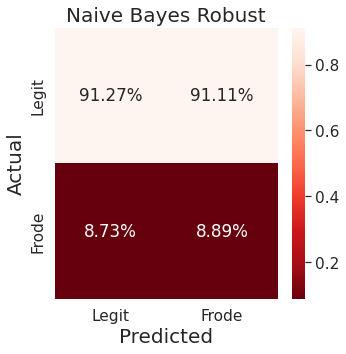

In [ ]:
confusionMatrix(y_test, y_pred_nbs,'Naive Bayes Standard')
confusionMatrix(y_test, y_pred_nbr,'Naive Bayes Robust')

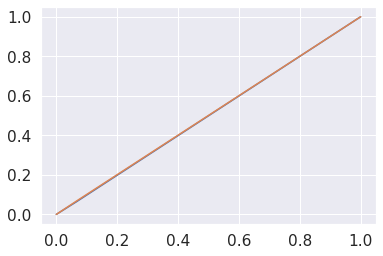

In [ ]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nbs)
auc = round(metrics.roc_auc_score(y_test, y_pred_nbs), 4)
plt.plot(fpr,tpr,label="Naive Bayes Standard, AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_nbr)
auc = round(metrics.roc_auc_score(y_test, y_pred_nbr), 4)
plt.plot(fpr,tpr,label="Naive Bayes Robust, AUC="+str(auc))

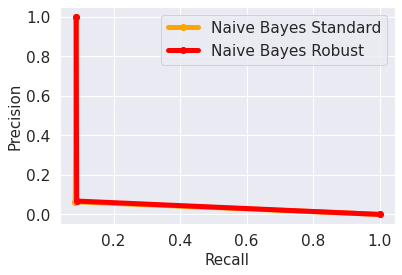

In [ ]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_nbs)
plt.plot(precision, recall, marker='o', label='Naive Bayes Standard',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_nbr)
plt.plot(precision, recall, marker='o', label='Naive Bayes Robust',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

##Decision tree e feature selection intrinseca

Questo dataset così pocco correlato ci permette di dimostrare che ...


La decisione dello smezzamento sull'entropia (max information gain) implica una feature selection intrinseca. Ci aspettiamo che i risultati pre e post feature selection siano simili.

In [473]:
from sklearn import tree

In [474]:
X = df.drop('fraud', axis=1)
Y = df['fraud']

In [475]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

In [476]:
dt = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=3).fit(X, Y)

[Text(0.5, 0.875, 'X[2] <= 4.0\nentropy = 0.428\nsamples = 700000\nvalue = [638818, 61182]\nclass = legit'),
 Text(0.25, 0.625, 'X[0] <= 100.004\nentropy = 0.168\nsamples = 627626\nvalue = [611984, 15642]\nclass = legit'),
 Text(0.125, 0.375, 'X[1] <= 49.999\nentropy = 0.052\nsamples = 596381\nvalue = [592868, 3513]\nclass = legit'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 587510\nvalue = [587510, 0]\nclass = legit'),
 Text(0.1875, 0.125, 'entropy = 0.969\nsamples = 8871\nvalue = [5358, 3513]\nclass = legit'),
 Text(0.375, 0.375, 'X[6] <= 0.5\nentropy = 0.964\nsamples = 31245\nvalue = [19116, 12129]\nclass = legit'),
 Text(0.3125, 0.125, 'entropy = 0.103\nsamples = 10975\nvalue = [10827, 148]\nclass = legit'),
 Text(0.4375, 0.125, 'entropy = 0.976\nsamples = 20270\nvalue = [8289, 11981]\nclass = fraud'),
 Text(0.75, 0.625, 'X[6] <= 0.5\nentropy = 0.951\nsamples = 72374\nvalue = [26834, 45540]\nclass = fraud'),
 Text(0.625, 0.375, 'X[3] <= 0.5\nentropy = 0.536\nsamples = 25365\nv

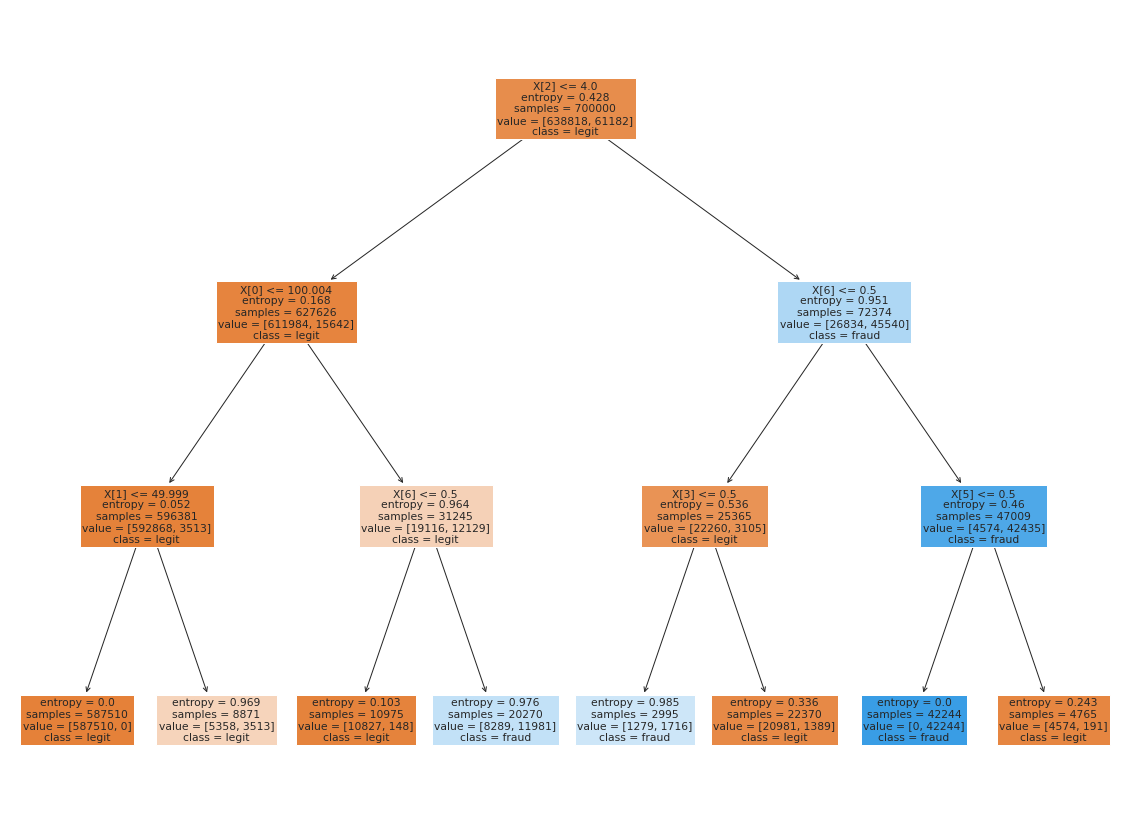

In [477]:
fig = plt.figure(figsize=(20,15))
tree.plot_tree(dt, class_names=['legit', 'fraud'], filled=True)

In [478]:
y_pred_dt = dt.predict(x_test)

In [479]:
y_pred_train_dt = dt.predict(X)

In [480]:
cm = confusion_matrix(y_test, y_pred_dt)

dt_Recall = recall_score(y_test, y_pred_dt)
dt_Precision = precision_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print(cm)

[[269688   4091]
 [  2317  23904]]


In [481]:
cm = confusion_matrix(Y, y_pred_train_dt)

dt_train_Recall = recall_score(Y, y_pred_train_dt)
dt_train_Precision = precision_score(Y, y_pred_train_dt)
dt_train_f1 = f1_score(Y, y_pred_train_dt)
dt_train_accuracy = accuracy_score(Y, y_pred_train_dt)

print(cm)

[[629250   9568]
 [  5241  55941]]


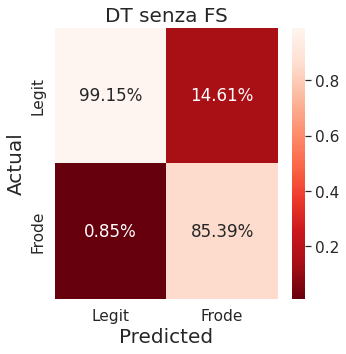

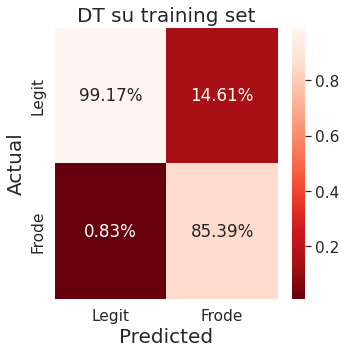

In [482]:
confusionMatrix(y_test, y_pred_dt,'DT senza FS')
confusionMatrix(Y, y_pred_train_dt,'DT su training set')

In [483]:
dt_ndf = [(dt_Recall, dt_Precision, dt_f1, dt_accuracy)]

dt_score = pd.DataFrame(data=dt_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_score.insert(0, 'Model', 'dt')
dt_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt,0.911636,0.853867,0.881806,0.97864


In [484]:
dt_train_ndf = [(dt_train_Recall, dt_train_Precision, dt_train_f1, dt_train_accuracy)]

dt_train_score = pd.DataFrame(data=dt_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_train_score.insert(0, 'Model', 'dt_train')
dt_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_train,0.914338,0.853944,0.883109,0.978844


In [485]:
columns = df.iloc[:, 0:7].columns

In [486]:
feature_imp = pd.Series(dt.feature_importances_, index=columns).sort_values(ascending = False)

In [487]:
feature_imp

ratio_to_median_purchase_price    0.483834
distance_from_home                0.171952
online_order                      0.165688
distance_from_last_transaction    0.087044
used_pin_number                   0.079310
repeat_retailer                   0.012171
used_chip                         0.000000
dtype: float64

####Applichiamo la feature selection al decision tree



<AxesSubplot: >

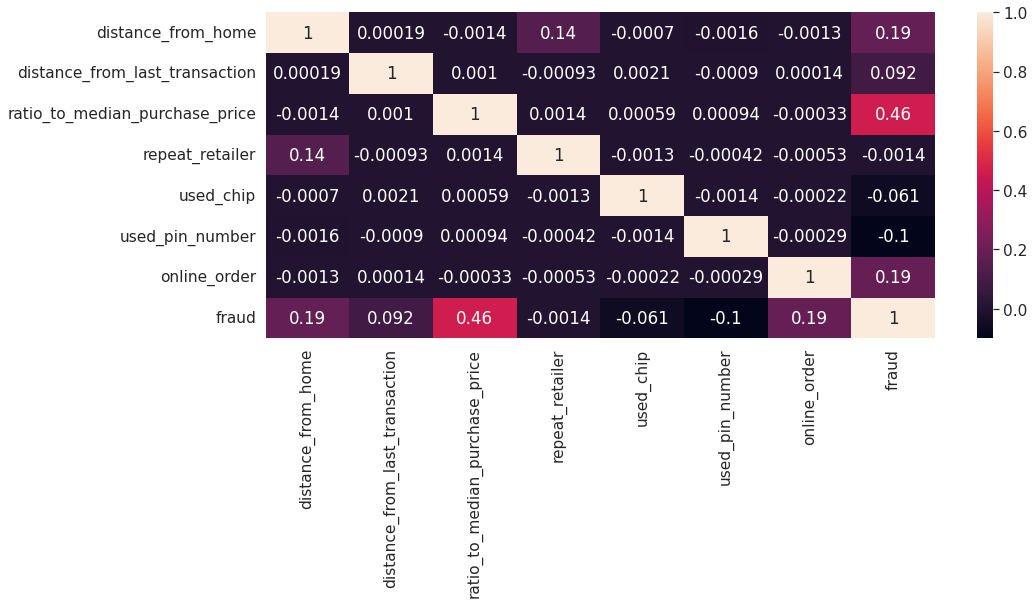

In [488]:
plt.figure(figsize = (15,6))
sns.heatmap(df.corr(), annot=True)

Osserviamo che le feature meno correlate sono... pertanto...

In [489]:
df_light = df.drop(['used_chip', 'repeat_retailer', 'used_pin_number'], axis=1)

In [490]:
df_light.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,online_order,fraud
0,57.877857,0.311140,1.945940,0.0,0.0
1,10.829943,0.175592,1.294219,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,0.0


In [491]:
X = df_light.drop('fraud', axis=1)
Y = df_light['fraud']

In [492]:
X, x_test, Y, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.3)

In [493]:
dt_fs = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3).fit(X, Y)

[Text(0.5, 0.875, 'X[2] <= 4.0\nentropy = 0.428\nsamples = 700000\nvalue = [638818, 61182]\nclass = legit'),
 Text(0.25, 0.625, 'X[0] <= 100.008\nentropy = 0.169\nsamples = 627957\nvalue = [612171, 15786]\nclass = legit'),
 Text(0.125, 0.375, 'X[1] <= 50.001\nentropy = 0.053\nsamples = 596488\nvalue = [592926, 3562]\nclass = legit'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 587673\nvalue = [587673, 0]\nclass = legit'),
 Text(0.1875, 0.125, 'entropy = 0.973\nsamples = 8815\nvalue = [5253, 3562]\nclass = legit'),
 Text(0.375, 0.375, 'X[3] <= 0.5\nentropy = 0.964\nsamples = 31469\nvalue = [19245, 12224]\nclass = legit'),
 Text(0.3125, 0.125, 'entropy = 0.11\nsamples = 10990\nvalue = [10830, 160]\nclass = legit'),
 Text(0.4375, 0.125, 'entropy = 0.977\nsamples = 20479\nvalue = [8415, 12064]\nclass = fraud'),
 Text(0.75, 0.625, 'X[3] <= 0.5\nentropy = 0.951\nsamples = 72043\nvalue = [26647, 45396]\nclass = fraud'),
 Text(0.625, 0.375, 'X[0] <= 1.9\nentropy = 0.545\nsamples = 25254\nva

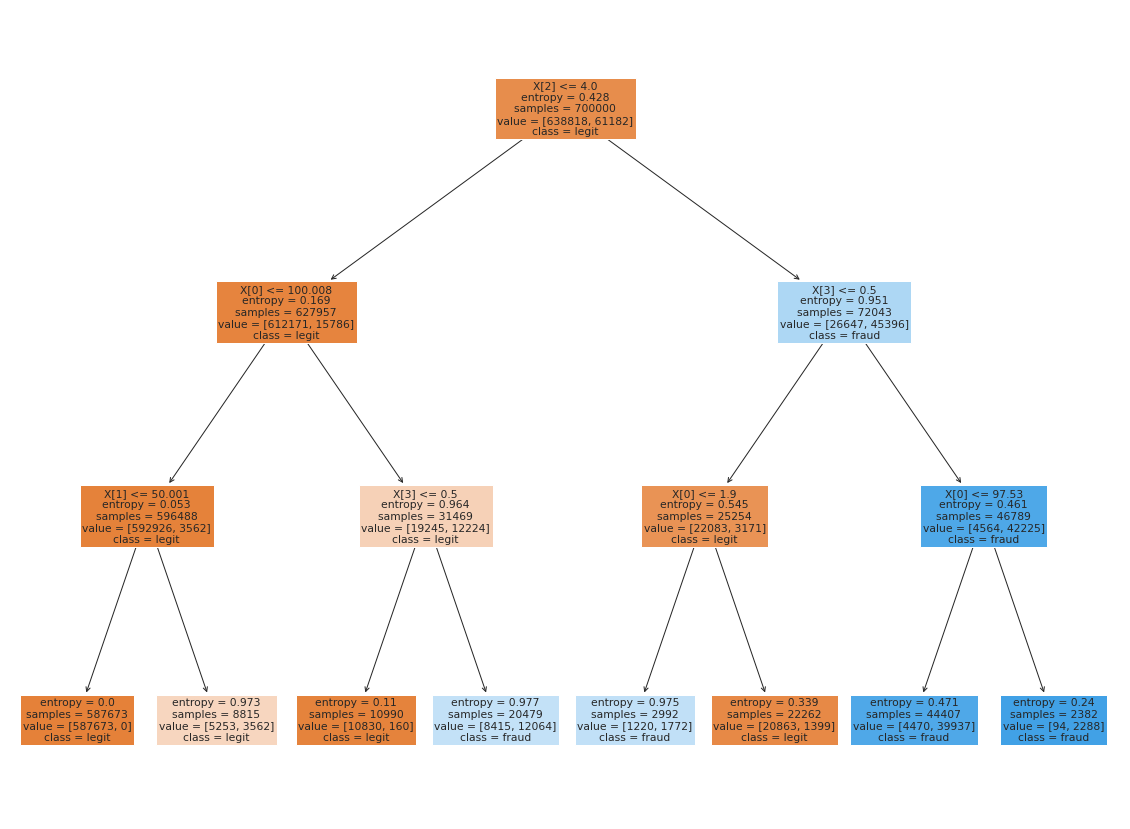

In [494]:
fig = plt.figure(figsize=(20,15))
tree.plot_tree(dt_fs, class_names=['legit', 'fraud'], filled=True)

In [495]:
y_pred_dt_fs = dt_fs.predict(x_test)

In [496]:
y_pred_train_dt_fs = dt_fs.predict(X)

In [497]:
cm = confusion_matrix(y_test, y_pred_dt_fs)

dt_fs_Recall = recall_score(y_test, y_pred_dt_fs)
dt_fs_Precision = precision_score(y_test, y_pred_dt_fs)
dt_fs_f1 = f1_score(y_test, y_pred_dt_fs)
dt_fs_accuracy = accuracy_score(y_test, y_pred_dt_fs)

print(cm)

[[267828   5951]
 [  2166  24055]]


In [498]:
cm = confusion_matrix(Y, y_pred_train_dt_fs)

dt_fs_train_Recall = recall_score(Y, y_pred_train_dt_fs)
dt_fs_train_Precision = precision_score(Y, y_pred_train_dt_fs)
dt_fs_train_f1 = f1_score(Y, y_pred_train_dt_fs)
dt_fs_train_accuracy = accuracy_score(Y, y_pred_train_dt_fs)

print(cm)

[[624619  14199]
 [  5121  56061]]


In [499]:
dt_fs_ndf = [(dt_fs_Recall, dt_fs_Precision, dt_fs_f1, dt_fs_accuracy)]

dt_fs_score = pd.DataFrame(data=dt_fs_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_fs_score.insert(0, 'Model', 'dt_fs')
dt_fs_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_fs,0.917394,0.801673,0.855639,0.972943


In [500]:
dt_fs_train_ndf = [(dt_fs_train_Recall, dt_fs_train_Precision, dt_fs_train_f1, dt_fs_train_accuracy)]

dt_fs_train_score = pd.DataFrame(data=dt_fs_train_ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
dt_fs_train_score.insert(0, 'Model', 'dt_train')
dt_fs_train_score

,Model,Recall,Precision,F1 Score,Accuracy
0,dt_train,0.916299,0.797908,0.853015,0.9724


###Confronto Performance

In [501]:
predictions = pd.concat([dt_score, dt_fs_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

,Model,Recall,Precision,F1 Score,Accuracy
1,dt_fs,0.917394,0.801673,0.855639,0.972943
0,dt,0.911636,0.853867,0.881806,0.978640


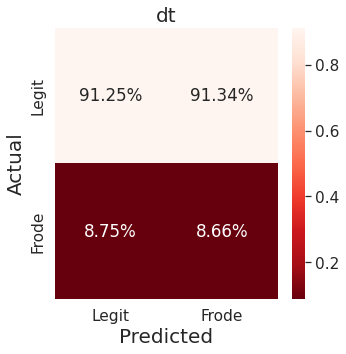

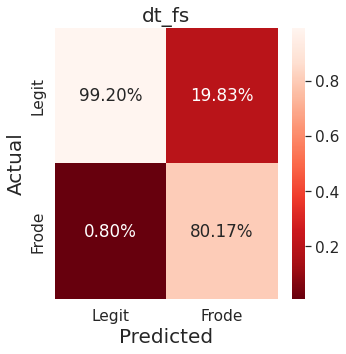

In [502]:
confusionMatrix(y_test, y_pred_dt,'dt')
confusionMatrix(y_test, y_pred_dt_fs,'dt_fs')

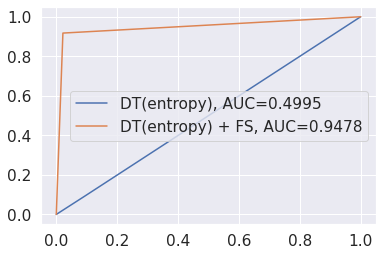

In [503]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_dt)
auc = round(metrics.roc_auc_score(y_test, y_pred_dt), 4)
plt.plot(fpr,tpr,label="DT(entropy), AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_dt_fs )
auc = round(metrics.roc_auc_score(y_test, y_pred_dt_fs ), 4)
plt.plot(fpr,tpr,label="DT(entropy) + FS, AUC="+str(auc))

#add legend
plt.legend()

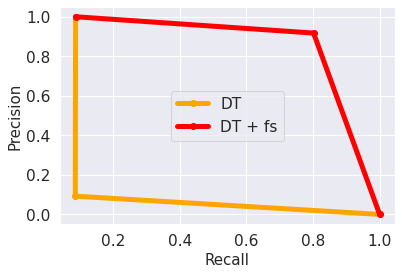

In [504]:
plt.figure(0).clf()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_dt)
plt.plot(precision, recall, marker='o', label='DT',color='orange',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()

precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_dt_fs)
plt.plot(precision, recall, marker='o', label='DT + fs',color='red',linewidth=5)
plt.xlabel('Recall',fontsize='15')
plt.ylabel('Precision',fontsize='15')
plt.legend()